In [9]:
import pandas as pd
import numpy as np
import xgboost
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [10]:
import numpy as np
import itertools
emb = np.load('../data/acc_data/training_img_embedding.npy',allow_pickle = True)
emb = emb[()]

In [11]:
train = pd.read_csv('../data/acc_data/training_large.csv')#,header = None)
test = pd.read_csv('../data/acc_data/validation_large.csv')#,header = None)

In [12]:
train.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,...,num_v_labels,ax,ay,az,vx_lag_1,vy_lag_1,vz_lag_1,vx_lag_2,vy_lag_2,vz_lag_2
0,-10.738884,-2.270775,-0.017484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-0.370861,0.324686,0.063559,-10.776157,-2.238142,-0.011096,-10.822652,-2.210152,-0.011221
1,-10.702093,-2.299289,-0.027242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-0.366060,0.283704,0.097093,-10.738884,-2.270775,-0.017484,-10.776157,-2.238142,-0.011096
2,-10.649046,-2.326863,-0.015441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-0.527806,0.274360,-0.117417,-10.702093,-2.299289,-0.027242,-10.738884,-2.270775,-0.017484
3,-10.598294,-2.345125,-0.018072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-0.504967,0.181704,0.026169,-10.649046,-2.326863,-0.015441,-10.702093,-2.299289,-0.027242
4,-10.558764,-2.369425,-0.021834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-0.393321,0.241773,0.037435,-10.598294,-2.345125,-0.018072,-10.649046,-2.326863,-0.015441


In [13]:
X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vy_lag_1','vz_lag_1','vx_lag_2','vy_lag_2','vz_lag_2']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()

# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)

#### Baseline 

In [14]:
model_XGB = make_pipeline(StandardScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ax,y_train_ax, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score is:  0.09447750482429518 



#### Improved model

In [15]:
train.describe()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,...,num_v_labels,ax,ay,az,vx_lag_1,vy_lag_1,vz_lag_1,vx_lag_2,vy_lag_2,vz_lag_2
count,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,1.543710e+05,1.543710e+05,154371.000000,154371.000000,...,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000,154371.000000
mean,-0.045204,0.280796,0.007444,15.898143,-0.020320,-0.155993,-3.725322e-01,8.820057e-03,0.006970,-0.004353,...,30.397743,0.018670,-0.005758,-0.000761,-0.043328,0.280218,0.007367,-0.041451,0.279619,0.007289
std,6.792466,6.762571,0.254348,20.432149,0.639231,7.362743,4.845964e+00,1.935924e-01,3.903491,5.701200,...,22.375148,0.588218,0.589930,0.303629,6.791483,6.761767,0.254404,6.790503,6.760985,0.254440
min,-29.725990,-28.805597,-1.870755,0.000000,-2.829590,-36.599137,-4.439295e+01,-2.205683e+00,-247.073979,-376.752497,...,0.000000,-4.877404,-5.027894,-5.537979,-29.725990,-28.805597,-1.870755,-29.725990,-28.805597,-1.870755
25%,-1.071360,-1.111340,-0.035837,0.000000,0.000000,-0.002183,0.000000e+00,0.000000e+00,0.000000,0.000000,...,15.000000,-0.160188,-0.185948,-0.091154,-1.071304,-1.114275,-0.035877,-1.070603,-1.117803,-0.035905
50%,0.000000,0.000000,0.000000,8.789853,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.443867,1.446956,0.041129,27.917728,0.053655,0.000000,3.985386e-13,5.387028e-14,0.000000,0.000000,...,41.000000,0.194520,0.178761,0.091352,1.447644,1.444984,0.040991,1.449968,1.443632,0.040942
max,29.348547,29.198553,2.021150,82.528374,2.869635,62.529255,3.654719e+01,3.251867e+00,229.525634,345.904727,...,170.000000,3.580917,4.984998,4.449774,29.348547,29.198553,2.021150,29.348547,29.198553,2.021150


In [16]:
# First we will try to see if RobustScaler helps.
model_XGB = make_pipeline(RobustScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ax,y_train_ax, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score is:  0.09388091744133001 



We can see a small increase in accuracy, so we will keep it. Now we will try three different models and see how they work, this models are:
* XGboost
* Gradient Boosting Regressor
* LightGBM Regressor

In [17]:
def boosting_models(X_train,y_train):
    
    categorical = X_train.dtypes == object
    
    model_GBC = make_pipeline(RobustScaler(), GradientBoostingRegressor(alpha = 0.85, n_estimators = 1000, max_depth = 3))
    model_LGB = make_pipeline(RobustScaler(), LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=800))
    model_XGB = make_pipeline(RobustScaler(), xgboost.XGBRegressor(gamma=0.05, learning_rate=0.05, max_depth=3, n_estimators=2500, reg_alpha=0.5, reg_lambda=0.85))

    print('Gradient Boosting score is: ' , -np.mean(cross_val_score(model_GBC,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    print('Light Gradient Boosting score is: ' , -np.mean(cross_val_score(model_LGB,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    print(' Extreme Gradient Boosting score is: ' , -np.mean(cross_val_score(model_XGB,X_train,y_train, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')
    
    
    return model_GBC, model_LGB,model_XGB

In [18]:
model_GBC, model_LGB, model_XGB = boosting_models(X_train_ax,y_train_ax)

Gradient Boosting score is:  0.10093361274003161 

Light Gradient Boosting score is:  0.13502102347675088 

 Extreme Gradient Boosting score is:  0.09388091744133001 



In [19]:
def stacking_model(X_train,y_train):
    
    lasso = Lasso(alpha = 1e-3)
    GBC = GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3)
    LGB = LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=800)
    XGB = xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3, n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

    categorical = X_train.dtypes == object
    model_SR = make_pipeline(RobustScaler(), StackingRegressor(regressors=[LGB,lasso,XGB], meta_regressor=lasso))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_median_absolute_error',cv=5, n_jobs = -1)
    print("Stacking Regressor score: ", -scores.mean(), ' std: ', scores.std())
    
    return model_SR

In [20]:
model_SR = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.07388176257654114  std:  0.0009114256853832003


#### Model validation

In [21]:
test.head(2)

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,...,ax,ay,az,vx_lag_1,vy_lag_1,vz_lag_1,pred_ax,vx_lag_2,vy_lag_2,vz_lag_2
0,-1.399296,-0.110872,-0.017601,19.351571,1.713411,1.385692,0.098483,0.017623,0.201597,-0.248766,...,-0.201692,0.248871,-0.039894,-1.419567,-0.085859,-0.021610,-0.311843,-1.481712,-0.096803,-0.014761
1,-1.369596,-0.089351,-0.016559,19.215781,1.675868,1.356016,0.076936,0.016581,0.295266,0.214385,...,-0.295503,-0.214125,-0.010365,-1.399296,-0.110872,-0.017601,-0.387300,-1.419567,-0.085859,-0.021610


In [22]:
X_val = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                    'vx_lag_1','vy_lag_1','vz_lag_1','vx_lag_2','vy_lag_2','vz_lag_2']]
y_val_ax = test.loc[:, ['ax']].values.ravel()
y_val_ay = test.loc[:, ['ay']].values.ravel()

In [23]:
model_SR.fit(X_train_ax,y_train_ax)
model_GBC.fit(X_train_ax,y_train_ax)
model_LGB.fit(X_train_ax,y_train_ax)
model_XGB.fit(X_train_ax,y_train_ax)
y_pred_SR = model_SR.predict(X_val)
y_pred_GBC = model_GBC.predict(X_val)
y_pred_LGB = model_LGB.predict(X_val)
y_pred_XGB = model_XGB.predict(X_val)

C:\Users\19296\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14359.226622520142, tolerance: 3.9925697822699755
  positive)


[23:21:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
print("MAE of SR:", mean_absolute_error(y_val_ax,y_pred_SR))
print("MAE of GBC:", mean_absolute_error(y_val_ax,y_pred_GBC))
print("MAE of LGB:", mean_absolute_error(y_val_ax,y_pred_LGB))
print("MAE of XGB:", mean_absolute_error(y_val_ax,y_pred_XGB))

MAE of SR: 0.13606096030089085
MAE of GBC: 0.23142620590427934
MAE of LGB: 0.3152533166661819
MAE of XGB: 0.2155003091404409


In [38]:
test['pred_ax'] = y_pred_XGB

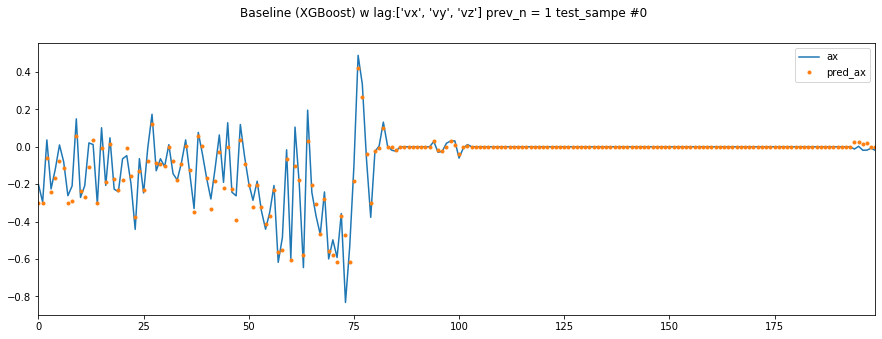

In [39]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 1 test_sample #0")

In [40]:
test['pred_ax'] = y_pred_SR

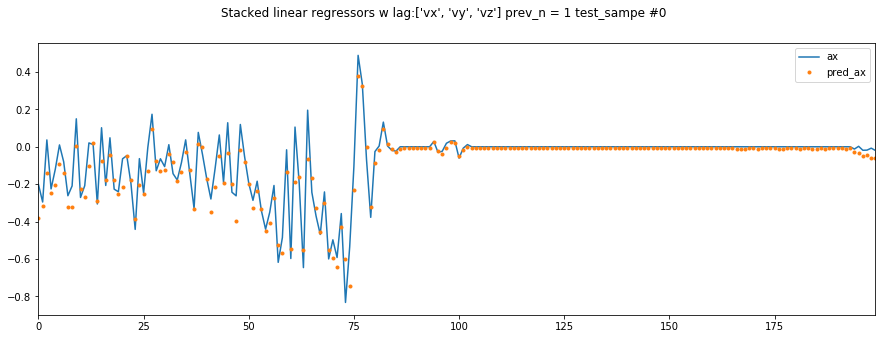

In [41]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Stacked linear regressors w lag:['vx', 'vy', 'vz'] prev_n = 1 test_sample #0")